# Generating CelebA figures

This notebook allows the creation of the CelebA figures using an existing model.

In [1]:
from models import *
from data import *
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import os
import random

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Loading model from weights
model = NP(128, [256, 256, 256, 128], [128, 256, 256, 6], deterministic_encoder_sizes=None)

# Loading CelebA data set. This will vary locally.
X_train = np.load("../NP/celeba/X_train-full_162770-res_32x32.npy")
X_test = np.load("../NP/celeba/X_test-full_19962-res_32x32.npy")

X_train = X_train.astype("float32").reshape(-1, 32 * 32, 3) / 255.
X_test = X_test.astype("float32").reshape(-1, 32 * 32, 3) / 255.

dataset_train = ImageDataGen(16, 1000, (32, 32), X_train)
(context_x, context_y), (target_x, target_y) = dataset_train.make_batch()
mu, sigma, _, _, loss = model(context_x, context_y, target_x, target_y=target_y)

model.load_weights("weights/celeba_weights.h5")

In [3]:
# Data generator for sampling different images 
# with different context sizes

from tensorflow.keras import datasets

class celebA_DataGen_multiple_context():
    def __init__(self, batch_size, context_nums=[10,100,300,784], testing=False, include_occ=False):
        
        # Loading CelebA data set. This will vary locally.
        X_train = np.load("../NP/celeba/X_train-full_162770-res_32x32.npy")
        X_test = np.load("../NP/celeba/X_test-full_19962-res_32x32.npy")

        X_train = X_train.astype("float32").reshape(-1, 32 * 32, 3) / 255.
        X_test = X_test.astype("float32").reshape(-1, 32 * 32, 3) / 255.
        
        if testing:
            self.X = X_test
        else:
            self.X = X_train

        self.x_values = np.indices((32, 32)).transpose(
            [1, 2, 0]).reshape((-1, 2)).astype("float32")
        self.x_values = np.tile(self.x_values, (batch_size, 1, 1))
        self.x_values = tf.constant(self.x_values)

        self.X = tf.constant(self.X)

        self.x_values = tf.constant(self.x_values)

        self.batch_size = batch_size
        self.context_nums = context_nums
        self.include_occ = include_occ
        

    def make_batch(self):
        img_idxs = tf.random.uniform(
            (self.batch_size,), minval=0, maxval=self.X.shape[0], dtype=tf.int32)

        y_values = tf.gather(self.X, img_idxs, axis=0)

        idxs = tf.random.shuffle(np.arange(32 * 32))
        
        context_x_list = []
        context_y_list = []
        
        for num_context in [15,30,90]:
            context_x_list += [tf.gather(self.x_values, idxs[:num_context], axis=1)]
            context_y_list += [tf.gather(y_values, idxs[:num_context], axis=1)]
            
        idxs = np.arange(32 * 32)
        
        if self.include_occ:     
            curr_idxs = np.where((idxs % 32 < 24) & (idxs % 32 > 7) & (idxs > 255) & (idxs < 768))[0]
            context_x_list += [tf.gather(self.x_values, curr_idxs, axis=1)]
            context_y_list += [tf.gather(y_values, curr_idxs, axis=1)]

            context_x_list += [tf.gather(self.x_values, idxs[512:], axis=1)]
            context_y_list += [tf.gather(y_values, idxs[512:], axis=1)]

            context_x_list += [tf.gather(self.x_values, idxs[:512], axis=1)]
            context_y_list += [tf.gather(y_values, idxs[:512], axis=1)]


            curr_idxs = idxs[idxs % 32 <16]
            context_x_list += [tf.gather(self.x_values, curr_idxs, axis=1)]
            context_y_list += [tf.gather(y_values, curr_idxs, axis=1)]

        context_x_list += [tf.gather(self.x_values, idxs, axis=1)]
        context_y_list += [tf.gather(y_values, idxs, axis=1)]

        return (context_x_list, context_y_list), (self.x_values, y_values)

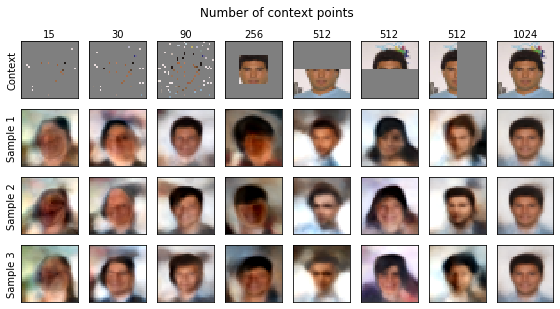

celeba_images/celeba_paper_0.jpg


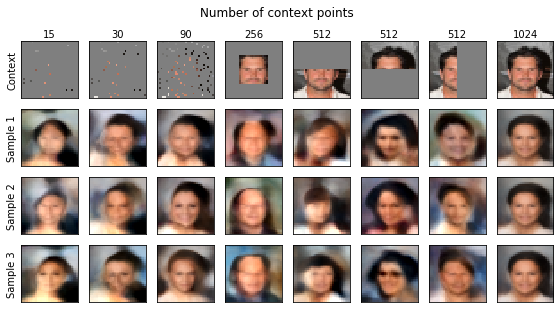

celeba_images/celeba_paper_1.jpg


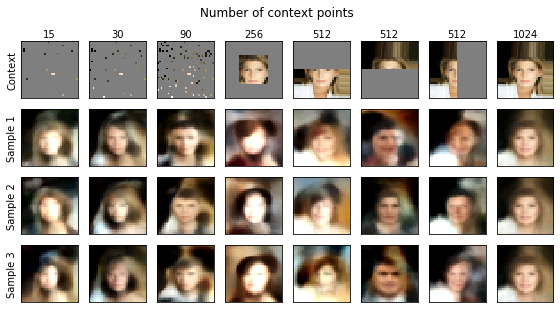

celeba_images/celeba_paper_2.jpg


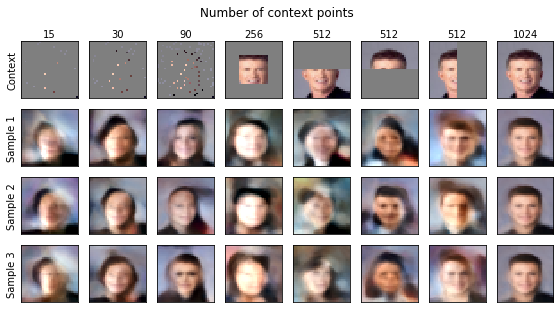

celeba_images/celeba_paper_3.jpg


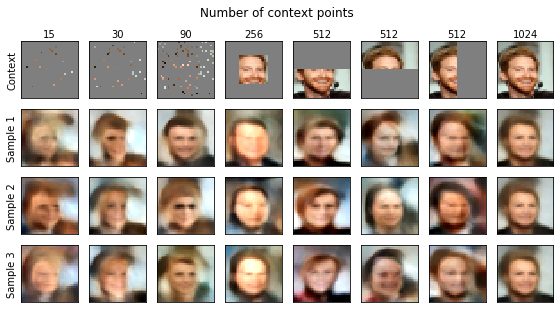

celeba_images/celeba_paper_4.jpg


In [4]:
# Plotting figures

random.seed(0)
tf.random.set_seed(0)
multiple_context_gen = celebA_DataGen_multiple_context(1, context_nums=[15,30,90,1024], include_occ=True)

def plot_mnist_paperstyle(context_x_list, context_y_list,target_x, target_y, model, 
                          file_name='celeba_paper.jpg', save=False):
    
    def add_points_to_img(x_vals,y_vals,img):
        for (x,y), val in zip(x_vals,y_vals):
            img[int(x),int(y)] = val
                
        return img
    
    def plot_single_img(context_x, context_y, target_x, model, num_samples=3):
        
        img = np.zeros((32,32,3)) + 0.5
        img = add_points_to_img(context_x[0], context_y[0], img)

        axs[0,j].imshow(img, cmap='gray')
        if j == 0:
            axs[0,j].set(ylabel='Context')
        axs[0,j].xaxis.set_label_position('top')
        axs[0,j].set(xlabel=str(context_x[0].shape[0]))
        
        for i in range(num_samples):
            mu, sigma, _, _, loss = model(context_x, context_y, target_x)
            mu, sigma = mu.numpy(), sigma.numpy()
            
            img = add_points_to_img(target_x[0], mu[0], img)

            img = np.clip(img, a_min=0, a_max=1)

            axs[1+i,j].imshow(img)
            if j == 0:
                axs[1+i,j].set(ylabel='Sample {}'.format(i+1))
    
    # set height to 12 if occlusion included
    fig, axs = plt.subplots(4, len(context_x_list), figsize=(1.5*len(context_x_list),4.8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.65, hspace=None)
    
    for j, (context_x, context_y) in enumerate(zip(context_x_list, context_y_list)):
        plot_single_img(context_x, context_y, target_x, model, num_samples=3)
        
    #for ax in axs.flat:
        #ax.set(xlabel='x-label', ylabel='y-label')
    for ax in axs.flat:
        ax.xaxis.set_ticks_position('top')
        ax.set_xticks([])
        ax.set_yticks([])
     
    fig.suptitle("Number of context points")
    
    if save:
        plt.savefig(file_name, format='jpg', dpi=600,bbox_inches="tight")
    plt.show()
    


    
for i in range(5):
    file_name = 'celeba_images/celeba_paper_{}.jpg'.format(i)
    (context_x_list, context_y_list), (target_x, target_y) = multiple_context_gen.make_batch()
    plot_mnist_paperstyle(context_x_list, context_y_list,target_x, target_y, model, file_name=file_name) 
    print(file_name)